# Treinamento regressão

In [1]:
treinar = {
    'GP': True,
    'RegressaoLinear': True
}

## Conjunto de dados

In [2]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('housesToRentProcessed.csv')

X = dataset[[
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
y = dataset[['y con + alu']].values

### Descrição do conjunto de dados

| Atributo         | Descrição                                           | Valor  |
| ---------------- | --------------------------------------------------- | ------ |
| `São Paulo`      | Imóvel está localizado na cidade de São Paulo?      | `int: 0 false - 1 true` |
| `Porto Alegre`   | Imóvel está localizado na cidade de Porto Alegre?   | `int: 0 false - 1 true` |
| `Rio de Janeiro` | Imóvel está localizado na cidade de Rio de Janeiro? | `int: 0 false - 1 true` |
| `Campinas`       | Imóvel está localizado na cidade de Campinas?       | `int: 0 false - 1 true` |
| `Belo Horizonte` | Imóvel está localizado na cidade de Belo Horizonte? | `int: 0 false - 1 true` |
| `area`           | Área do imóvel (em metros quadrados)                | `float` |
| `rooms`          | Quantidade de quartos                               | `int` |
| `bathroom`       | Quantidade de banheiros                             | `int` |
| `floor`          | Andar localizado o imóvel                           | `int`. `0` pressuposto para casa |
| `isHouse`        | Imóvel corresponde a um aluguel de casa             | `int: 0 false - 1 true` |
| `animal`         | É possivel levar animais para o imóvel              | `int: 0 false - 1 true` |
| `furniture`      | ?                      | `int: 0 false - 1 true` |
| `y con + alu`    | Valor mensal total do aluguel do imóvel: aluguel + taxa de condomínio. | `float` |

In [3]:
dataset.head()

,São Paulo,Porto Alegre,Rio de Janeiro,Campinas,Belo Horizonte,area,rooms,bathroom,parking spaces,floor,isHouse,animal,furniture,y con + alu
0,1,0,0,0,0,70,2,1,1,7,0,1,1,5365
1,1,0,0,0,0,320,4,4,0,20,0,1,0,6160
2,0,1,0,0,0,80,1,1,1,6,0,1,0,3800
3,0,1,0,0,0,51,2,1,0,2,0,1,0,1382
4,1,0,0,0,0,25,1,1,0,1,0,0,0,800


### Separação de treino e teste

Os dados foram separados em treino e em teste seguindo a proporção de $70\%$ para treino e de $30\%$ para testes. O processo de seleção do modelo será descrito posteriormente.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train = X_train[:10]
# y_train = y_train[:10]

print('Quantidade de elementos para o treinamento:', X_train.shape)
print('Quantidade de elementos selecionados para teste:', X_test.shape)

Quantidade de elementos para o treinamento: (7484, 13)
Quantidade de elementos selecionados para teste: (3208, 13)


### Normalização

A normalização aplicada no conjunto de dados foi a [min/max scalling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler):
\begin{aligned}
\mathcal{D}_{std} &= \frac{\mathcal{D} - \mathcal{D}.min(axis=0)}{\mathcal{D}.max(axis=0) - \mathcal{D}.min(axis=0)}; \\
\mathcal{D}_{scaled} &= \mathcal{D}_{std} \cdot (max - min) + min.
\end{aligned}
A transformação aplicada, escala (dimensiona) e translada cada característica individualmente, de modo que esta esteja entre o intervalo $[0, 1]$.

Como poderá ser visto adiante, este trabalho tomou o cuidado dos dados de validação e de teste serem transformados conforme os dados  a escala definida no treinamento.

In [5]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler

## Treinamento

Com o intuito de selecionar os melhores hiperparâmetros, para cada um dos modelo testados, foi realizado uma validação cruzada por meio de _5-folds_, onde ocorreu uma otimização bayesiana em cada um dos _folds_. Os hiperparâmetros foram selecionados de acordo com o resultado da métrica **DECIDIR**, descrita adiante neste trabalho.

Após a seleção dos hiperparâmetros, cada um dos modelos foram avaliados com conjunto de testes por meio das métricas descritas a seguir.

### Métricas

#### Root Mean Squared Error (RMSE)

__Root Mean Squared Error__ ou raiz do erro quadrático médio [_terminar_]

\begin{aligned}
\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \frac{1}{N_\text{teste}} \sum_{i=1}^{N_\text{teste}} (y_i - \hat{y}_i)^2; \\
\text{RMSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \sqrt{\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}})}
\end{aligned}

In [6]:
from sklearn.metrics import mean_squared_error

rmse = lambda a, b: mean_squared_error(a, b, squared=False)

#### Negative Log Predictive Density (NLPD)

A métrica **Negative Log Predictive Density** (NLPD) leva em consideração a variância predita $\hat{\sigma}_i^2$, além dos valores esperados e preditos (média):

\begin{aligned}
\text{NLPD}
&= -\frac{1}{N_\text{teste}}
    \sum_{i=1}^{N_\text{teste}}
    \log 
    \overbrace{p(y_i|\boldsymbol{x}_i, \boldsymbol{y}, \boldsymbol{X}, \hat{\boldsymbol{\theta}})}^{\mathcal{N}(y_i|\hat{\mu}_i, \hat{\sigma}_i^2)}
    \\
&= \frac{1}{2}\log2\pi + \frac{1}{2 N_\text{teste}}
\sum_{i=1}^{N_\text{teste}} \left[\log \hat{\sigma}^2_i + \frac{(y_i - \hat{\mu}_i)^2}{\hat{\sigma}^2_i}\right]
\end{aligned}

Conforme já discutido em aula, a NLPD busca realçar modelos equilibrandos, penalizando:
* modelos muito confiantes nos casos de erros grandes ($\sigma^2_i$ baixos para erros maiores), e;
* modelos pouco confiantes nos casos de erros pequenos ($\sigma^2_i$ altos para erros menores).

In [7]:
# Basedo em
# https://github.com/learningtitans/bayesian_uncertainty/blob/7b6ccce0f78a/src/bayesian_uncertainty/metrics.py
from scipy import stats
EPSILON = 1e-30


def nlpd(predicao_mean, predicao_std, validacao):
    predicao_std = predicao_std.copy()
    predicao_std[predicao_std < EPSILON] = EPSILON
    return -stats.norm(predicao_mean, predicao_std).logpdf(validacao).mean()

## Modelos utilizados

In [8]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])

### Processos Gaussianos

In [9]:
from trabalho.modelos.gp import GP

GP

trabalho.modelos.gp.GP

#### Hiperparâmetros a serem procurados

In [10]:
from trabalho.util.otimizacao_bayesiana import Dominio
import gpflow


kernels = [
    # Combinação de kernels
    #gpflow.kernels.Combination(),
    #gpflow.kernels.ChangePoints(),
    #gpflow.kernels.Product(),
    #gpflow.kernels.Sum(),
    
    # Imagem (convolução)
    #gpflow.kernels.Convolutional(),
    
    # Dados estacionários
    #gpflow.kernels.Stationary(),
    #gpflow.kernels.Periodic(), # Can be used to wrap any Stationary kernel to transform it into a periodic version
    #gpflow.kernels.AnisotropicStationary(), 
    #gpflow.kernels.IsotropicStationary(),
    
    # Multi objetivo
    #gpflow.kernels.MultioutputKernel(),
    #gpflow.kernels.IndependentLatent(),
    #gpflow.kernels.LinearCoregionalization(),
    #gpflow.kernels.SeparateIndependent(),
    #gpflow.kernels.SharedIndependent(),
    
    # Outros exóticos
    #gpflow.kernels.Coregion(),
    
    # Ok
    #gpflow.kernels.Kernel(), # Classe base
    #gpflow.kernels.Static(), # Classe base
    
    gpflow.kernels.ArcCosine(),
    gpflow.kernels.Constant(),
    gpflow.kernels.Cosine(),
    gpflow.kernels.Exponential(),
    gpflow.kernels.Linear(),
    
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
    
    gpflow.kernels.Polynomial(),
    gpflow.kernels.SquaredExponential(), # RBF
    gpflow.kernels.RationalQuadratic(),
    
    gpflow.kernels.White(),
]


dominio_gp = Dominio([
    # https://gpflow.readthedocs.io/en/master/gpflow/kernels/#gpflow-kernels-linear
    {
        'name': 'kernel',
        'type': 'categorical',
        'domain': kernels
    },
#     {'name': 'learning_rate',   'type': 'continuous', 'domain': (0.0001, 0.02)},
#     {'name': 'sampling_method', 'type': 'discrete',   'domain': (1, 3, 5)},
#     {'name': 'regularization',  'type': 'continuous', 'domain': (0.00001, 0.01)},
#     {'name': 'batch_size',      'type': 'discrete',   'domain': (10, 16, 32)},
])

dominio_gp.dominio

[{'name': 'kernel',
  'type': 'categorical',
  'domain': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}]

### Regressão Linear

In [11]:
from trabalho.modelos.regressao_linear import RegressaoLinear

RegressaoLinear

trabalho.modelos.regressao_linear.RegressaoLinear

#### Hiperparâmetros a serem procurados

In [12]:
dominio_regressao_linear = Dominio([])

### Validação - Seleção de modelos

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

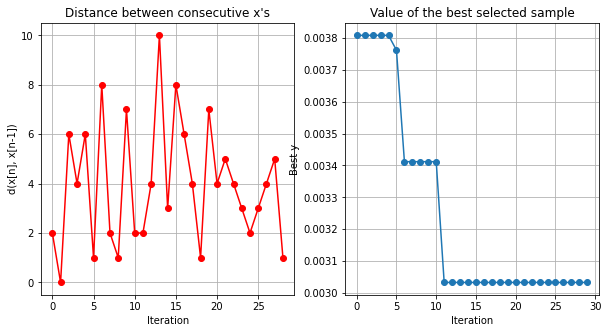

k-fold:  20%|██        | 1/5 [05:21<21:24, 321.21s/it]

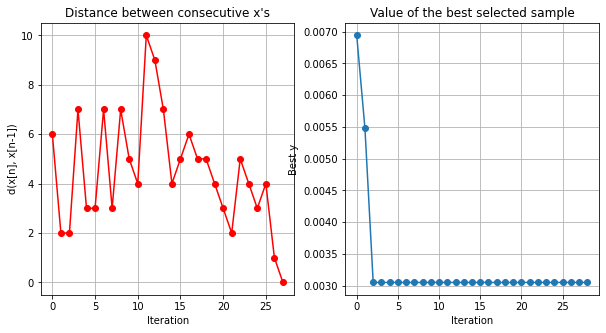

k-fold:  40%|████      | 2/5 [10:41<16:01, 320.64s/it]

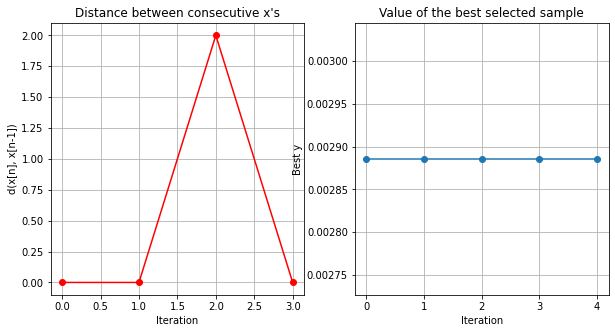

k-fold:  60%|██████    | 3/5 [11:31<06:34, 197.25s/it]

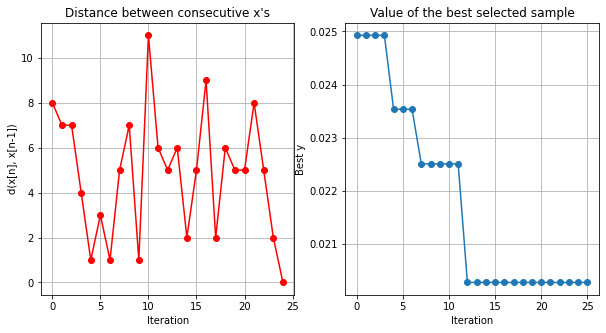

k-fold:  80%|████████  | 4/5 [16:42<04:01, 241.98s/it]

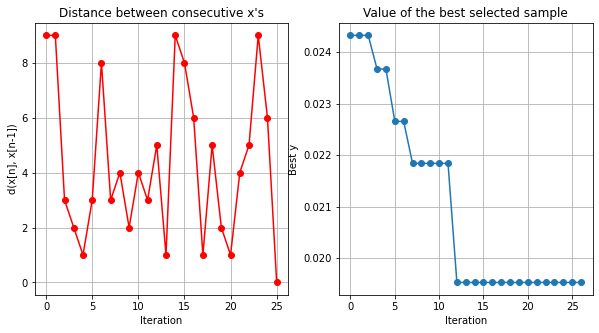

k-fold: 100%|██████████| 5/5 [22:04<00:00, 264.86s/it]


,modelo,parametros,rmse,nlpd,fold
0,GP,{'kernel': <gpflow.kernels.stationaries.Expone...,0.003808,-1.992220,0
1,GP,{'kernel': <gpflow.kernels.stationaries.Matern...,0.004029,-1.569977,0
2,GP,{'kernel': <gpflow.kernels.stationaries.Matern...,0.004029,-1.569977,0
3,GP,{'kernel': <gpflow.kernels.statics.White objec...,0.005423,0.918953,0
4,GP,{'kernel': <gpflow.kernels.stationaries.Matern...,0.004652,-3.277192,0


In [13]:
from trabalho.util.kfold import KFoldCrossValidation
from GPyOpt.methods import BayesianOptimization
from tqdm import tqdm

def f(Modelo, X, y, X_validation, y_validation, fold, relatorio, **kwargs):
    modelo = Modelo(**kwargs)
    modelo.fit(X, y)
    
    means, vars = modelo.predict(X_validation)
    
    erro_rmse = rmse(means, y_validation)
    erro_nlpd = nlpd(means, vars, y_validation)

    relatorio.loc[len(relatorio)] = [Modelo.__name__, kwargs, erro_rmse, erro_nlpd, fold]

    return erro_rmse


def validacao_cruzada(Modelo, dominio, X, y, max_iter=25, k_folds=5):
    relatorio = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])
    
    for i, X_train, X_test, y_train, y_test in tqdm(KFoldCrossValidation(X, y, k_folds).split(), total=k_folds, desc="k-fold"):
        X_scaler = Scaler()
        y_scaler = Scaler()
        
        X            = X_scaler.fit_transform(X_train)
        X_validation = X_scaler.transform(X_test)
        y            = y_scaler.fit_transform(y_train)
        y_validation = y_scaler.transform(y_test)

        funcao = dominio.gerar_f(Modelo=Modelo, f=f, X=X, y=y, X_validation=X_validation, y_validation=y_validation, fold=i, relatorio=relatorio)
        
        bo = BayesianOptimization(f=funcao, domain=dominio.dominio, verbosity=True)
        bo.run_optimization(max_iter=25)

#         print('RMSE:', bo.fx_opt, '(normalizado)')
#         print('RMSE:', y_scaler.inverse_transform([[bo.fx_opt]])[0, 0], '("real")')
#         print('Parâmetros:', bo.x_opt)
        try:
            bo.plot_convergence()
            bo.plot_acquisition()
        except Exception as e:
            print(e)

    return relatorio

if treinar['GP']:
    resultado_parcial = validacao_cruzada(Modelo=GP, dominio=dominio_gp, X=X_train, y=y_train)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])

relatorio_modelos.head()

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

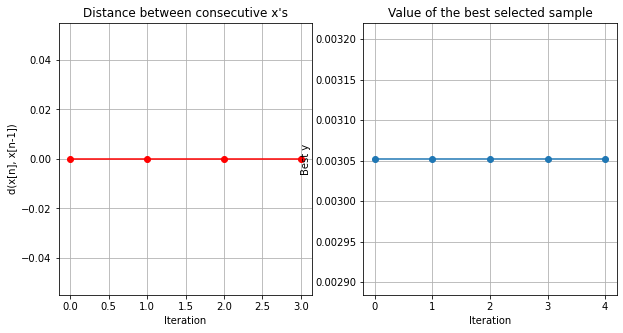

k-fold:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

not enough values to unpack (expected 2, got 0)


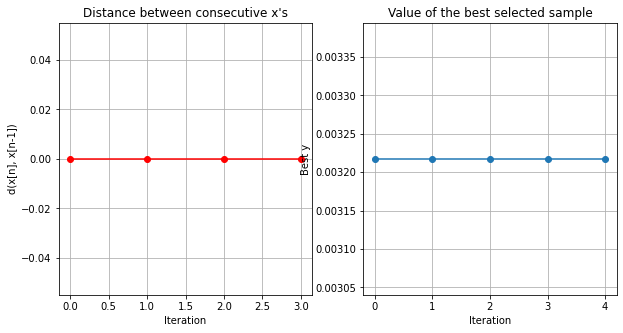

k-fold:  40%|████      | 2/5 [00:01<00:02,  1.43it/s]

not enough values to unpack (expected 2, got 0)


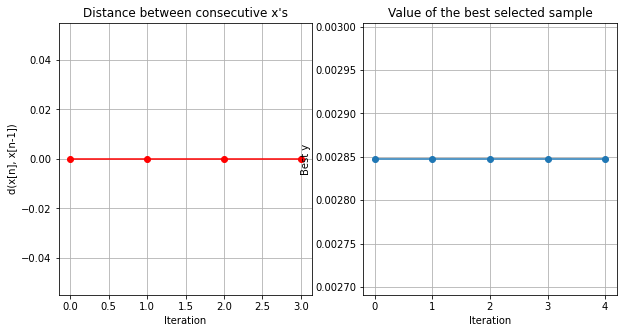

k-fold:  60%|██████    | 3/5 [00:01<00:01,  1.60it/s]

not enough values to unpack (expected 2, got 0)


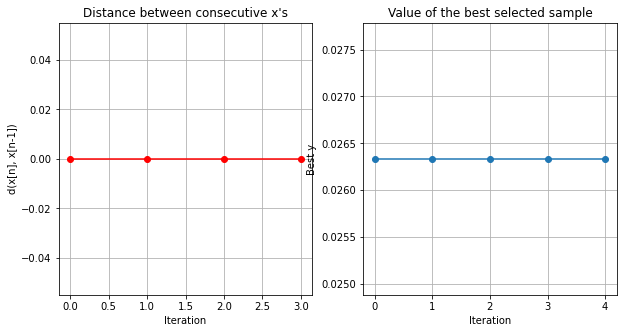

k-fold:  80%|████████  | 4/5 [00:02<00:00,  1.64it/s]

not enough values to unpack (expected 2, got 0)


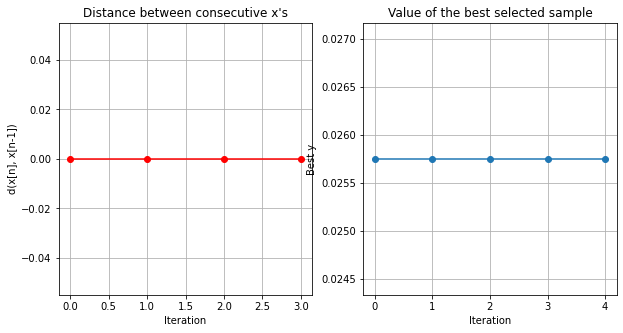

k-fold: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

not enough values to unpack (expected 2, got 0)


In [14]:
if treinar['RegressaoLinear']:
    resultado_parcial = validacao_cruzada(Modelo=RegressaoLinear, dominio=dominio_regressao_linear, X=X_train, y=y_train)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])

#### Resultado prelimiar

In [15]:
relatorio_modelos.sort_values(['rmse', 'nlpd']).groupby(['modelo', 'fold']).first()

parametros  \
modelo          fold                                                      
GP              0     {'kernel': <gpflow.kernels.linears.Linear obje...   
                1     {'kernel': <gpflow.kernels.linears.Linear obje...   
                2     {'kernel': <gpflow.kernels.stationaries.Expone...   
                3     {'kernel': <gpflow.kernels.stationaries.Matern...   
                4     {'kernel': <gpflow.kernels.stationaries.Matern...   
RegressaoLinear 0                                                    {}   
                1                                                    {}   
                2                                                    {}   
                3                                                    {}   
                4                                                    {}   

                          rmse          nlpd  
modelo          fold                          
GP              0     0.003033 -3.625577e+00  
                1     0.003052 -3.626155e+00  
                2     0.002886 -2.299353e+00  
                3     0.020282 -1.931521e+00  
                4     0.019531 -1.977724e+00  
RegressaoLinear 0     0.003052  4.657752e+54  
                1     0.003217  5.175952e+54  
                2     0.002848  4.054630e+54  
                3     0.026334  3.467462e+56  
                4     0.025749  3.315169e+56